## Baseline Modeling:
- no hyperparam tuning. save for grid search
- should i do on scaled or not? PCA?



In [444]:
#load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [445]:
#read data
df = pd.read_csv('my_data_no_mets_organ_primary.csv', index_col='Sample ID')

In [446]:
#check out the data
df.head()

,Age at Sequencing,Age at Surgical Procedure,Fraction Genome Altered,Metastatic patient,Met Count,Met Site Count,MSI Score,MSI Instable,Sample coverage,TMB (nonsynonymous),Tumor Purity,Average Age,Year Group Encoded
Sample ID,,,,,,,,,,,,,
P-0000004-T01-IM3,39.74,37.03,0.2782,1,2,2,2.50,0,428,4.436621,50.0,39.1225,1
P-0000015-T01-IM3,44.44,44.42,0.3503,1,8,8,2.55,0,281,7.764087,40.0,44.6775,2
P-0000024-T01-IM3,61.33,61.00,0.3878,1,8,5,0.72,0,1016,6.654932,40.0,61.5050,3
P-0000025-T02-IM5,74.81,74.64,0.1020,1,13,8,0.15,0,1147,1.957439,30.0,73.9075,3
P-0000026-T01-IM3,71.72,71.58,0.4196,1,11,7,1.23,0,1222,4.436621,10.0,72.5350,4


In [447]:
#check the shape
df.shape

(25771, 13)

In [448]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#split off a validation set for hyperparameter tuning from X_train_full and y_train_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train_full.shape}, X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full:{y_train_full.shape}, y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}')

Shape of: X_train_full:(20616, 12), X_train:(16492, 12), X_val:(4124, 12), X_test:(5155, 12)
Shape of: y_train_full:(20616,), y_train:(16492,), y_val:(4124,), y_test:(5155,)


In [449]:
#scale the data:

#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full)

#transform train and test dataframes
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [450]:
#convert X_train scaled to a df

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns).set_index(X_train_full.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [451]:
#necessary libraries
import statsmodels.api as sm

# Add a constant to the X
X_train_with_const = sm.add_constant(X_train_scaled_df)

In [452]:
# Fit the multinomial logistic regression model
mnlogit_model = sm.MNLogit(y_train, X_train_with_const)
mnlogit_result = mnlogit_model.fit()

# Get the summary of the regression
print(mnlogit_result.summary())

Optimization terminated successfully.
         Current function value: 1.113153
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:     Year Group Encoded   No. Observations:                16492
Model:                        MNLogit   Df Residuals:                    16453
Method:                           MLE   Df Model:                           36
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.1616
Time:                        16:30:57   Log-Likelihood:                -18358.
converged:                       True   LL-Null:                       -21897.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     Year Group Encoded=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1505      0.022      6.790      0.000       0.

In [453]:
df.drop(columns='MSI Score', inplace=True)

In [454]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#split off a validation set for hyperparameter tuning from X_train_full and y_train_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train_full.shape}, X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full:{y_train_full.shape}, y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}')

Shape of: X_train_full:(20616, 11), X_train:(16492, 11), X_val:(4124, 11), X_test:(5155, 11)
Shape of: y_train_full:(20616,), y_train:(16492,), y_val:(4124,), y_test:(5155,)


In [455]:
#scale the data:

#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full)

#transform train and test dataframes
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [456]:
#convert X_train scaled to a df

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns).set_index(X_train_full.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [457]:
#necessary libraries
import statsmodels.api as sm

# Add a constant to the X
X_train_with_const = sm.add_constant(X_train_scaled_df)

# Fit the multinomial logistic regression model
mnlogit_model = sm.MNLogit(y_train, X_train_with_const)
mnlogit_result = mnlogit_model.fit()

# Get the summary of the regression
print(mnlogit_result.summary())

Optimization terminated successfully.
         Current function value: 1.113712
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:     Year Group Encoded   No. Observations:                16492
Model:                        MNLogit   Df Residuals:                    16456
Method:                           MLE   Df Model:                           33
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.1612
Time:                        16:30:57   Log-Likelihood:                -18367.
converged:                       True   LL-Null:                       -21897.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     Year Group Encoded=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1519      0.022      6.857      0.000       0.

In [458]:
df.drop(columns='TMB (nonsynonymous)', inplace=True)

In [459]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#split off a validation set for hyperparameter tuning from X_train_full and y_train_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train_full.shape}, X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full:{y_train_full.shape}, y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}')

Shape of: X_train_full:(20616, 10), X_train:(16492, 10), X_val:(4124, 10), X_test:(5155, 10)
Shape of: y_train_full:(20616,), y_train:(16492,), y_val:(4124,), y_test:(5155,)


In [460]:
#scale the data:

#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full)

#transform train and test dataframes
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [461]:
#convert X_train scaled to a df

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns).set_index(X_train_full.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [462]:
#necessary libraries
import statsmodels.api as sm

# Add a constant to the X
X_train_with_const = sm.add_constant(X_train_scaled_df)

# Fit the multinomial logistic regression model
mnlogit_model = sm.MNLogit(y_train, X_train_with_const)
mnlogit_result = mnlogit_model.fit()

# Get the summary of the regression
print(mnlogit_result.summary())

Optimization terminated successfully.
         Current function value: 1.114335
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:     Year Group Encoded   No. Observations:                16492
Model:                        MNLogit   Df Residuals:                    16459
Method:                           MLE   Df Model:                           30
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.1607
Time:                        16:30:58   Log-Likelihood:                -18378.
converged:                       True   LL-Null:                       -21897.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     Year Group Encoded=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1524      0.022      6.887      0.000       0.

In [463]:
df.drop(columns='MSI Instable', inplace=True)

In [464]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#split off a validation set for hyperparameter tuning from X_train_full and y_train_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train_full.shape}, X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full:{y_train_full.shape}, y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}')

Shape of: X_train_full:(20616, 9), X_train:(16492, 9), X_val:(4124, 9), X_test:(5155, 9)
Shape of: y_train_full:(20616,), y_train:(16492,), y_val:(4124,), y_test:(5155,)


In [465]:
#scale the data:

#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full)

#transform train and test dataframes
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [466]:
#convert X_train scaled to a df

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns).set_index(X_train_full.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [467]:
#necessary libraries
import statsmodels.api as sm

# Add a constant to the X
X_train_with_const = sm.add_constant(X_train_scaled_df)

# Fit the multinomial logistic regression model
mnlogit_model = sm.MNLogit(y_train, X_train_with_const)
mnlogit_result = mnlogit_model.fit()

# Get the summary of the regression
print(mnlogit_result.summary())

Optimization terminated successfully.
         Current function value: 1.116557
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:     Year Group Encoded   No. Observations:                16492
Model:                        MNLogit   Df Residuals:                    16462
Method:                           MLE   Df Model:                           27
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.1590
Time:                        16:30:58   Log-Likelihood:                -18414.
converged:                       True   LL-Null:                       -21897.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     Year Group Encoded=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1581      0.022      7.163      0.000       0.

In [468]:
df.drop(columns='Tumor Purity', inplace=True)


In [469]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#split off a validation set for hyperparameter tuning from X_train_full and y_train_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train_full.shape}, X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full:{y_train_full.shape}, y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}')

Shape of: X_train_full:(20616, 8), X_train:(16492, 8), X_val:(4124, 8), X_test:(5155, 8)
Shape of: y_train_full:(20616,), y_train:(16492,), y_val:(4124,), y_test:(5155,)


In [470]:
#scale the data:

#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full)

#transform train and test dataframes
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [471]:
#convert X_train scaled to a df

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns).set_index(X_train_full.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [472]:
#necessary libraries
import statsmodels.api as sm

# Add a constant to the X
X_train_with_const = sm.add_constant(X_train_scaled_df)

# Fit the multinomial logistic regression model
mnlogit_model = sm.MNLogit(y_train, X_train_with_const)
mnlogit_result = mnlogit_model.fit()

# Get the summary of the regression
print(mnlogit_result.summary())

Optimization terminated successfully.
         Current function value: 1.118067
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:     Year Group Encoded   No. Observations:                16492
Model:                        MNLogit   Df Residuals:                    16465
Method:                           MLE   Df Model:                           24
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.1579
Time:                        16:30:58   Log-Likelihood:                -18439.
converged:                       True   LL-Null:                       -21897.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     Year Group Encoded=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1568      0.022      7.111      0.000       0.

In [473]:
df.drop(columns='Fraction Genome Altered', inplace=True)


In [474]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#split off a validation set for hyperparameter tuning from X_train_full and y_train_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train_full.shape}, X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full:{y_train_full.shape}, y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}')

Shape of: X_train_full:(20616, 7), X_train:(16492, 7), X_val:(4124, 7), X_test:(5155, 7)
Shape of: y_train_full:(20616,), y_train:(16492,), y_val:(4124,), y_test:(5155,)


In [475]:
#scale the data:

#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full)

#transform train and test dataframes
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [476]:
#convert X_train scaled to a df

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns).set_index(X_train_full.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [477]:

# Add a constant to the X
X_train_with_const = sm.add_constant(X_train_scaled_df)

# Fit the multinomial logistic regression model
mnlogit_model = sm.MNLogit(y_train, X_train_with_const)
mnlogit_result = mnlogit_model.fit()

# Get the summary of the regression
print(mnlogit_result.summary())

Optimization terminated successfully.
         Current function value: 1.118257
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:     Year Group Encoded   No. Observations:                16492
Model:                        MNLogit   Df Residuals:                    16468
Method:                           MLE   Df Model:                           21
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.1578
Time:                        16:30:58   Log-Likelihood:                -18442.
converged:                       True   LL-Null:                       -21897.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     Year Group Encoded=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1556      0.022      7.062      0.000       0.

In [478]:
df.drop(columns='Metastatic patient', inplace=True)


In [479]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#split off a validation set for hyperparameter tuning from X_train_full and y_train_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train_full.shape}, X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full:{y_train_full.shape}, y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}')

Shape of: X_train_full:(20616, 6), X_train:(16492, 6), X_val:(4124, 6), X_test:(5155, 6)
Shape of: y_train_full:(20616,), y_train:(16492,), y_val:(4124,), y_test:(5155,)


In [480]:
#scale the data:

#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full)

#transform train and test dataframes
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [481]:
#convert X_train scaled to a df

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns).set_index(X_train_full.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [482]:

# Add a constant to the X
X_train_with_const = sm.add_constant(X_train_scaled_df)

# Fit the multinomial logistic regression model
mnlogit_model = sm.MNLogit(y_train, X_train_with_const)
mnlogit_result = mnlogit_model.fit()

# Get the summary of the regression
print(mnlogit_result.summary())

Optimization terminated successfully.
         Current function value: 1.121227
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:     Year Group Encoded   No. Observations:                16492
Model:                        MNLogit   Df Residuals:                    16471
Method:                           MLE   Df Model:                           18
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.1555
Time:                        16:30:59   Log-Likelihood:                -18491.
converged:                       True   LL-Null:                       -21897.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     Year Group Encoded=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1543      0.022      7.010      0.000       0.

### Logistic Regression

In [483]:
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Make predictions
preds = log_reg.predict(X_val_scaled)

# Compute metrics
accuracy_lg = accuracy_score(y_val, preds)
precision_lg = precision_score(y_val, preds, average='weighted')
recall_lg = recall_score(y_val, preds, average='weighted')
f1_lg = f1_score(y_val, preds, average='weighted')
conf_mat_lg = confusion_matrix(y_val, preds)
clf_report_lg = classification_report(y_val, preds)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg}")
print(f"Precision: {precision_lg}")
print(f"Recall: {recall_lg}")
print(f"F1 Score: {f1_lg}")
print("Confusion Matrix:")
print(conf_mat_lg)
print("Classification Report:")
print(clf_report_lg)

Logistic Regression Metrics:
Accuracy: 0.5761396702230844
Precision: 0.5843759171981588
Recall: 0.5761396702230844
F1 Score: 0.5664231286266896
Confusion Matrix:
[[862 333  52   5]
 [436 627 193  14]
 [133 206 759  31]
 [ 41  21 283 128]]
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.69      0.63      1252
           2       0.53      0.49      0.51      1270
           3       0.59      0.67      0.63      1129
           4       0.72      0.27      0.39       473

    accuracy                           0.58      4124
   macro avg       0.61      0.53      0.54      4124
weighted avg       0.58      0.58      0.57      4124



### KNN 

### Decision Tree Classifier

In [484]:
# Initialize the model
dec_tree = DecisionTreeClassifier(random_state=42)

# Train the model
dec_tree.fit(X_train, y_train)

# Make predictions
preds = dec_tree.predict(X_val)

# Compute metrics
accuracy_dt = accuracy_score(y_val, preds)
precision_dt = precision_score(y_val, preds, average='weighted')
recall_dt = recall_score(y_val, preds, average='weighted')
f1_dt = f1_score(y_val, preds, average='weighted')
conf_mat_dt = confusion_matrix(y_val, preds)
clf_report_dt = classification_report(y_val, preds)

# Print metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")
print("Confusion Matrix:")
print(conf_mat_dt)
print("Classification Report:")
print(clf_report_dt)

Decision Tree Metrics:
Accuracy: 0.3957322987390883
Precision: 0.39421127587582
Recall: 0.3957322987390883
F1 Score: 0.3946680249389642
Confusion Matrix:
[[534 405 236  77]
 [364 537 288  81]
 [226 311 450 142]
 [ 92 101 169 111]]
Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.43      0.43      1252
           2       0.40      0.42      0.41      1270
           3       0.39      0.40      0.40      1129
           4       0.27      0.23      0.25       473

    accuracy                           0.40      4124
   macro avg       0.37      0.37      0.37      4124
weighted avg       0.39      0.40      0.39      4124



### XG Boost

In [485]:
y_train_adjusted = y_train - 1
y_val_adjusted = y_val - 1

# Initialize the model
xgb = XGBClassifier(random_state=42, eval_metric='auc')

# Train the model
xgb.fit(X_train, y_train_adjusted)

# Make predictions
preds = xgb.predict(X_val)

# Compute metrics
accuracy_xgb = accuracy_score(y_val_adjusted, preds)
precision_xgb = precision_score(y_val_adjusted, preds, average='weighted')
recall_xgb = recall_score(y_val_adjusted, preds, average='weighted')
f1_xgb = f1_score(y_val_adjusted, preds, average='weighted')
conf_mat_xgb = confusion_matrix(y_val_adjusted, preds)
clf_report_xgb = classification_report(y_val_adjusted, preds)

# Print metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1 Score: {f1_xgb}")
print("Confusion Matrix:")
print(conf_mat_xgb)
print("Classification Report:")
print(clf_report_xgb)

XGBoost Metrics:
Accuracy: 0.549466537342386
Precision: 0.5516930733443205
Recall: 0.549466537342386
F1 Score: 0.5450124812739251
Confusion Matrix:
[[863 320  55  14]
 [404 653 198  15]
 [153 314 584  78]
 [ 50  55 202 166]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.69      0.63      1252
           1       0.49      0.51      0.50      1270
           2       0.56      0.52      0.54      1129
           3       0.61      0.35      0.45       473

    accuracy                           0.55      4124
   macro avg       0.56      0.52      0.53      4124
weighted avg       0.55      0.55      0.55      4124



Use SMOTE:

In [486]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [487]:
#apply smote to the training set

# Initialize SMOTE
smote = SMOTE(random_state=42)

X_train_full_sm, y_train_full_sm = smote.fit_resample(X_train_full, y_train_full)

In [488]:
#see what smote has done
print('Original class distribution')
display(pd.Series(y_train_full).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_full_sm).value_counts().sort_index())

Original class distribution


Year Group Encoded
1    6259
2    6350
3    5641
4    2366
Name: count, dtype: int64


Resampled class distribution


Year Group Encoded
1    6350
2    6350
3    6350
4    6350
Name: count, dtype: int64

In [489]:
#split off a validation set for hyperparameter tuning from X_train_full_sm and y_train_full_sm
X_train_sm, X_val_sm, y_train_sm, y_val_sm = train_test_split(X_train_full_sm, y_train_full_sm, test_size=0.2, random_state=42, stratify=y_train_full_sm)

In [490]:
#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full_sm)

#transform train and test dataframes
X_train_scaled_sm = scaler.transform(X_train_sm)
X_val_scaled_sm = scaler.transform(X_val_sm)
X_train_full_scaled_sm = scaler.transform(X_train_full_sm)
X_test_scaled_sm = scaler.transform(X_test)

In [491]:
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Train the model
log_reg.fit(X_train_scaled_sm, y_train_sm)

# Make predictions
preds = log_reg.predict(X_val_scaled_sm)

# Compute metrics
accuracy_lg = accuracy_score(y_val_sm, preds)
precision_lg = precision_score(y_val_sm, preds, average='weighted')
recall_lg = recall_score(y_val_sm, preds, average='weighted')
f1_lg = f1_score(y_val_sm, preds, average='weighted')
conf_mat_lg = confusion_matrix(y_val_sm, preds)
clf_report_lg = classification_report(y_val_sm, preds)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg}")
print(f"Precision: {precision_lg}")
print(f"Recall: {recall_lg}")
print(f"F1 Score: {f1_lg}")
print("Confusion Matrix:")
print(conf_mat_lg)
print("Classification Report:")
print(clf_report_lg)

Logistic Regression Metrics:
Accuracy: 0.572244094488189
Precision: 0.5617982765585173
Recall: 0.572244094488189
F1 Score: 0.5592010756547721
Confusion Matrix:
[[ 897  289   48   36]
 [ 442  517  243   68]
 [ 144  197  484  445]
 [  81   52  128 1009]]
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.71      0.63      1270
           2       0.49      0.41      0.44      1270
           3       0.54      0.38      0.45      1270
           4       0.65      0.79      0.71      1270

    accuracy                           0.57      5080
   macro avg       0.56      0.57      0.56      5080
weighted avg       0.56      0.57      0.56      5080



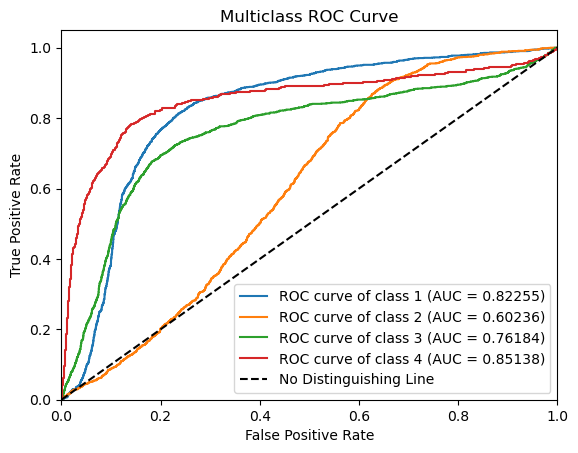

In [636]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

y_probs = log_reg.predict_proba(X_test_scaled_sm)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC pre_Tuned Log', dpi=300)
plt.show()

In [493]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Define undersampling strategy (to downsample the majority classes)
under = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Create a pipeline
pipeline = Pipeline(steps=[('o', smote), ('u', under)])

# Transform the dataset
X_train_full_resampled, y_train_full_resampled = pipeline.fit_resample(X_train_full, y_train_full)

# Check the new class distribution vs the old
#see what smote has done
print('Original class distribution')
display(pd.Series(y_train_full).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_full_resampled).value_counts().sort_index())


Original class distribution


Year Group Encoded
1    6259
2    6350
3    5641
4    2366
Name: count, dtype: int64


Resampled class distribution


Year Group Encoded
1    6350
2    6350
3    6350
4    6350
Name: count, dtype: int64

In [494]:
#split off a validation set for hyperparameter tuning from X_train_full_sm and y_train_full_sm
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_train_full_resampled, y_train_full_resampled, test_size=0.2, random_state=42, stratify=y_train_full_resampled)

In [495]:
#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full_resampled)

#transform train and test dataframes
X_train_scaled_resampled = scaler.transform(X_train_resampled)
X_val_scaled_resampled = scaler.transform(X_val_resampled)
X_train_full_scaled_resampled = scaler.transform(X_train_full_resampled)
X_test_scaled_resampled = scaler.transform(X_test)

In [496]:
# Initialize the model
log_reg_2 = LogisticRegression(random_state=42)

# Train the model
log_reg_2.fit(X_train_scaled_resampled, y_train_resampled)

# Make predictions
preds = log_reg_2.predict(X_val_scaled_resampled)

# Compute metrics
accuracy_lg = accuracy_score(y_val_resampled, preds)
precision_lg = precision_score(y_val_resampled, preds, average='weighted')
recall_lg = recall_score(y_val_resampled, preds, average='weighted')
f1_lg = f1_score(y_val_resampled, preds, average='weighted')
conf_mat_lg = confusion_matrix(y_val_resampled, preds)
clf_report_lg = classification_report(y_val_resampled, preds)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg}")
print(f"Precision: {precision_lg}")
print(f"Recall: {recall_lg}")
print(f"F1 Score: {f1_lg}")
print("Confusion Matrix:")
print(conf_mat_lg)
print("Classification Report:")
print(clf_report_lg)

Logistic Regression Metrics:
Accuracy: 0.5712598425196851
Precision: 0.5618187831544065
Recall: 0.5712598425196851
F1 Score: 0.5593325953595994
Confusion Matrix:
[[885 299  53  33]
 [444 497 250  79]
 [156 160 521 433]
 [ 83  53 135 999]]
Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.70      0.62      1270
           2       0.49      0.39      0.44      1270
           3       0.54      0.41      0.47      1270
           4       0.65      0.79      0.71      1270

    accuracy                           0.57      5080
   macro avg       0.56      0.57      0.56      5080
weighted avg       0.56      0.57      0.56      5080



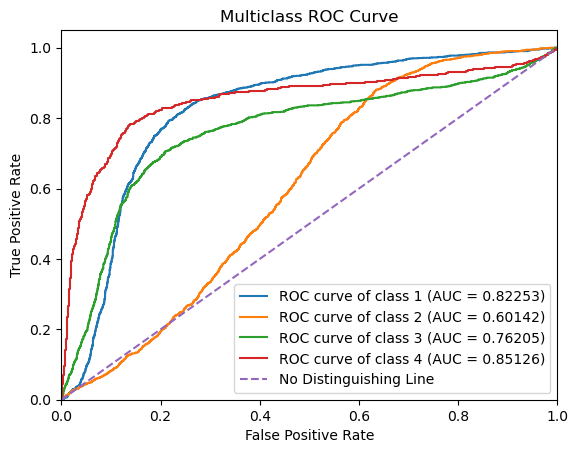

In [588]:
# Binarize the output
y_test_binarized2 = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized2.shape[1]

y_probs2 = log_reg_2.predict_proba(X_test_scaled_resampled)

# Compute ROC curve and ROC area for each class
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()

for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_test_binarized2[:, i], y_probs2[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

# Plot all ROC curves
plt.figure()

for i in range(n_classes):
    plt.plot(fpr2[i], tpr2[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc2[i]:.5f})')

plt.plot([0, 1], [0, 1], '--', label='No Distinguishing Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")

plt.show()


### Random Forest Classifier?

In [ ]:
# Initialize the model
rand_forest = RandomForestClassifier(random_state=42)

# Train the model
rand_forest.fit(X_train, y_train)

# Make predictions
preds = rand_forest.predict(X_val)

# Compute metrics
accuracy_rf = accuracy_score(y_val, preds)
precision_rf = precision_score(y_val, preds)
recall_rf = recall_score(y_val, preds)
f1_rf = f1_score(y_val, preds)
conf_mat_rf = confusion_matrix(y_val, preds)
clf_report_rf = classification_report(y_val, preds)

# Print metrics
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
print(conf_mat_rf)
print("Classification Report:")
print(clf_report_rf)

KNN

In [504]:
#import necessary libraries
from sklearn.neighbors import KNeighborsClassifier

#Instantiate the model & fit it to our data
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train_scaled_sm, y_train_sm)

# Make predictions
preds = KNN_model.predict(X_val_scaled_sm)

# Compute metrics
accuracy_knn = accuracy_score(y_val_sm, preds)
precision_knn = precision_score(y_val_sm, preds, average='weighted')
recall_knn = recall_score(y_val_sm, preds, average='weighted')
f1_knn = f1_score(y_val_sm, preds, average='weighted')
conf_mat_knn = confusion_matrix(y_val_sm, preds)
clf_report_knn = classification_report(y_val_sm, preds)

# Print metrics
print("KNN Metrics:")
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")
print("Confusion Matrix:")
print(conf_mat_knn)
print("Classification Report:")
print(clf_report_knn)

KNN Metrics:
Accuracy: 0.38405511811023624
Precision: 0.39004126663895383
Recall: 0.38405511811023624
F1 Score: 0.3845143008061653
Confusion Matrix:
[[524 405 195 146]
 [472 424 223 151]
 [359 347 349 215]
 [205 188 223 654]]
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.41      0.37      1270
           2       0.31      0.33      0.32      1270
           3       0.35      0.27      0.31      1270
           4       0.56      0.51      0.54      1270

    accuracy                           0.38      5080
   macro avg       0.39      0.38      0.38      5080
weighted avg       0.39      0.38      0.38      5080



### SVM - OvO or OvA?
- see feature_new.ipynb

In [514]:
#OvR

from sklearn.svm import SVC

# Define the SVM classifier (One-vs-All strategy is used by default)
svm_model_OvA = SVC(random_state=42, decision_function_shape='ovr').fit(X_train_scaled_sm, y_train_sm)


# Make predictions
preds_OvA = svm_model_OvA.predict(X_val_scaled_sm)

# Compute metrics
accuracy_OvA = accuracy_score(y_val_sm, preds_OvA)
precision_OvA = precision_score(y_val_sm, preds_OvA, average='weighted')
recall_OvA = recall_score(y_val_sm, preds_OvA, average='weighted')
f1_OvA = f1_score(y_val_sm, preds_OvA, average='weighted')
conf_mat_OvA = confusion_matrix(y_val_sm, preds_OvA)
clf_report_OvA = classification_report(y_val_sm, preds_OvA)

# Print metrics
print("OvA Metrics:")
print(f"Accuracy: {accuracy_OvA}")
print(f"Precision: {precision_OvA}")
print(f"Recall: {recall_OvA}")
print(f"F1 Score: {f1_OvA}")
print("Confusion Matrix:")
print(conf_mat_OvA)
print("Classification Report:")
print(clf_report_OvA)


OvA Metrics:
Accuracy: 0.4561023622047244
Precision: 0.45919911617906733
Recall: 0.4561023622047244
F1 Score: 0.45247088849868766
Confusion Matrix:
[[485 564 106 115]
 [289 618 224 139]
 [167 368 407 328]
 [ 72 137 254 807]]
Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.38      0.42      1270
           2       0.37      0.49      0.42      1270
           3       0.41      0.32      0.36      1270
           4       0.58      0.64      0.61      1270

    accuracy                           0.46      5080
   macro avg       0.46      0.46      0.45      5080
weighted avg       0.46      0.46      0.45      5080



In [515]:
#OvO

from sklearn.multiclass import OneVsOneClassifier

# Define the SVM classifier (One-vs-All strategy is used by default)
svm_model_OvO = OneVsOneClassifier(SVC(random_state=42)).fit(X_train_scaled_sm, y_train_sm)

# Make predictions
preds_OvO = svm_model_OvO.predict(X_val_scaled_sm)

# Compute metrics
accuracy_OvO = accuracy_score(y_val_sm, preds_OvO)
precision_OvO = precision_score(y_val_sm, preds_OvO, average='weighted')
recall_OvO = recall_score(y_val_sm, preds_OvO, average='weighted')
f1_OvO = f1_score(y_val_sm, preds_OvO, average='weighted')
conf_mat_OvO = confusion_matrix(y_val_sm, preds_OvO)
clf_report_OvO = classification_report(y_val_sm, preds_OvO)

# Print metrics
print("OvO Metrics:")
print(f"Accuracy: {accuracy_OvO}")
print(f"Precision: {precision_OvO}")
print(f"Recall: {recall_OvO}")
print(f"F1 Score: {f1_OvO}")
print("Confusion Matrix:")
print(conf_mat_OvO)
print("Classification Report:")
print(clf_report_OvO)



OvO Metrics:
Accuracy: 0.4549212598425197
Precision: 0.4581806233834126
Recall: 0.4549212598425197
F1 Score: 0.45117039070858844
Confusion Matrix:
[[468 568 119 115]
 [273 622 237 138]
 [160 363 414 333]
 [ 68 135 260 807]]
Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.37      0.42      1270
           2       0.37      0.49      0.42      1270
           3       0.40      0.33      0.36      1270
           4       0.58      0.64      0.61      1270

    accuracy                           0.45      5080
   macro avg       0.46      0.45      0.45      5080
weighted avg       0.46      0.45      0.45      5080



## Summary of Baseline models:

In [ ]:
# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the baseline models
metrics_df.loc['Logistic Regression'] = [accuracy_lg, precision_lg, recall_lg, f1_lg]
#metrics_df.loc['SVM'] = [accuracy_svm, precision_svm, recall_svm, f1_svm]
metrics_df.loc['Decision Tree'] = [accuracy_dt, precision_dt, recall_dt, f1_dt]
metrics_df.loc['Random Forest'] = [accuracy_rf, precision_rf, recall_rf, f1_rf]
metrics_df.loc['XGBoost'] = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]

# Print the comparison table
print(metrics_df)

In [ ]:
#Line chart with metrics (Accuracy)

# List of model names and corresponding accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_lg, accuracy_dt, accuracy_rf, accuracy_xgb]

# Plot the line graph with an orange color theme and grid lines
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, color='orange', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison for Baseline Models', fontweight='bold')
plt.ylim(0.6, 1.0)  # Set y-axis limits to 0.6 to 1.0
plt.axhline(y=0.6, color='gray', linestyle='--')  # Add a horizontal line at y=0.6 for reference

# Add accuracy score labels
for i, score in enumerate(accuracy_scores):
    plt.text(models[i], score, f"{score*100:.1f}%", ha='center', va='bottom')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add both horizontal and vertical grid lines
plt.show()


In [ ]:
# bar chart comparing precision, recall and f1 and (maybe add accuracy) - how to do with 4 classes? 
# List of model names and corresponding precision, recall, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision_scores = [precision_lg, precision_dt, precision_rf, precision_xgb]
recall_scores = [recall_lg, recall_dt, recall_rf, recall_xgb]
f1_scores = [f1_lg, f1_dt, f1_rf, f1_xgb]

# Convert scores to percentages with one decimal place
precision_scores_pct = [round(score * 100, 1) for score in precision_scores]
recall_scores_pct = [round(score * 100, 1) for score in recall_scores]
f1_scores_pct = [round(score * 100, 1) for score in f1_scores]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.25

# Plot the bar graph for precision with an orange color theme
plt.figure(figsize=(12, 6))
plt.bar(pos, precision_scores_pct, width, color='darkorange', alpha=0.4, label='Precision')

# Plot the bar graph for recall with a darker orange color
plt.bar(pos + width, recall_scores_pct, width, color='orange', label='Recall')

# Plot the bar graph for F1 score with a much darker orange color
plt.bar(pos + 2 * width, f1_scores_pct, width, color='saddlebrown', alpha=0.7, label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.title('Precision, Recall, and F1 Score Comparison for Baseline Models', fontweight='bold')
plt.xticks(pos + width, models, rotation=360)
plt.legend()

# Add score labels on top of the bars
for i in range(len(models)):
    plt.text(pos[i], precision_scores_pct[i], f"{precision_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width, recall_scores_pct[i], f"{recall_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + 2 * width, f1_scores_pct[i], f"{f1_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.show()

# Hyperparameter Tuning

## Grid Search with Cross Validation 

Steps:

 - redo the train test split - we will use cross valiudation so we do not need a validation set
 - scaling will be done in the pipeline to ensure it is done in the correct way as only the train data being scaled for each k-fold
 - redo smote upsampling


In [532]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full: y_train:{y_train.shape}, y_test:{y_test.shape}')


Shape of: X_train_full:(20616, 6), X_test:(5155, 6)
Shape of: y_train_full: y_train:(20616,), y_test:(5155,)


In [533]:
#apply smote to the training set to upsample the minority classes

# Initialize SMOTE
smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [534]:
#see what smote has done
print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


Year Group Encoded
1    6259
2    6350
3    5641
4    2366
Name: count, dtype: int64


Resampled class distribution


Year Group Encoded
1    6350
2    6350
3    6350
4    6350
Name: count, dtype: int64

### Logistic Regression

In [542]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

from tempfile import mkdtemp
from sklearn.model_selection import GridSearchCV


estimators = [('normalise', StandardScaler()),  ('model', LogisticRegression(random_state=42))] #('dim_reducer', PCA())

#build estimator list trat this as a placeholder
cachedir = mkdtemp()
pipe=Pipeline(estimators, memory=cachedir)

param_grid = [
            {'model': [LogisticRegression(random_state=42, solver='liblinear')],
            'normalise': [StandardScaler(), MinMaxScaler(), None],
            'model__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
            'model__penalty': ['l1', 'l2', None]},
            
            {'model': [LogisticRegression(random_state=42, solver='saga')],
            'normalise': [StandardScaler(), MinMaxScaler(), None],
            'model__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
            'model__penalty': ['l1', 'l2', 'elastinet', None]}]

            # 'dim_reducer': [PCA(), KernelPCA()],
            # 'dim_reducer__n_components': [2, 3, 4]}]

#Instantiate the GridSearch
        
grid = GridSearchCV(pipe, param_grid, cv=5)

#fit the grid search to the train data
fittedgrid = grid.fit(X_train_sm, y_train_sm)

#display the best estimator
fittedgrid.best_estimator_

             

Pipeline(memory='/var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmpnnvqboht',
         steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=1000.0, random_state=42, solver='saga'))])

In [543]:
print(fittedgrid.best_estimator_)


Pipeline(memory='/var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmpnnvqboht',
         steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=1000.0, random_state=42, solver='saga'))])


In [546]:
#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full_sm)

#scale the data
#instantiate scaler
ss= StandardScaler()

#fit scaler to train data
ss.fit(X_train_sm)

#transform train and test
X_train_sm_ss = ss.transform(X_train_sm)
X_test_ss = ss.transform(X_test)


#instantiate model with best parameteres from above
logreg_1 = LogisticRegression(random_state=42, C=1000.0, solver='saga')

#fit the model
logreg_1.fit(X_train_sm_ss, y_train_sm)

#make predictions
logreg_1_pred = logreg_1.predict(X_test_ss)

#compute metrics

accuracy_lg1 = accuracy_score(y_test, logreg_1_pred)
precision_lg1 = precision_score(y_test, logreg_1_pred, average='weighted')
recall_lg1 = recall_score(y_test, logreg_1_pred, average='weighted')
f1_lg1 = f1_score(y_test, logreg_1_pred, average='weighted')
conf_mat_lg1 = confusion_matrix(y_test, logreg_1_pred)
clf_report_lg1 = classification_report(y_test, logreg_1_pred)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg1}")
print(f"Precision: {precision_lg1}")
print(f"Recall: {recall_lg1}")
print(f"F1 Score: {f1_lg1}")
print("Confusion Matrix:")
print(conf_mat_lg1)
print("Classification Report:")
print(clf_report_lg1)



Logistic Regression Metrics:
Accuracy: 0.5416100872938894
Precision: 0.5473484021689532
Recall: 0.5416100872938894
F1 Score: 0.535330070072331
Confusion Matrix:
[[1053  411   65   36]
 [ 486  662  367   73]
 [ 158  170  624  459]
 [  49   31   58  453]]
Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.67      0.64      1565
           2       0.52      0.42      0.46      1588
           3       0.56      0.44      0.49      1411
           4       0.44      0.77      0.56       591

    accuracy                           0.54      5155
   macro avg       0.53      0.57      0.54      5155
weighted avg       0.55      0.54      0.54      5155



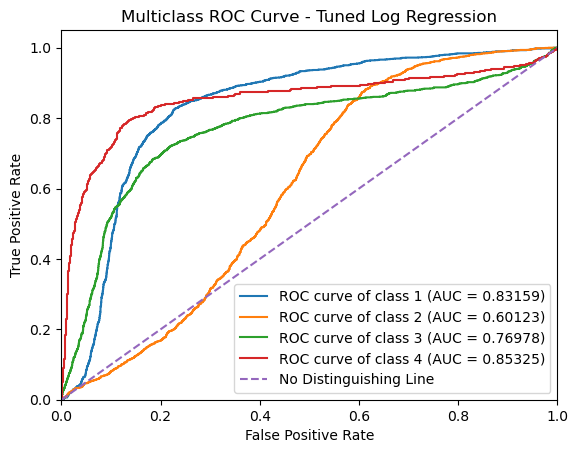

In [590]:
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

y_probs = logreg_1.predict_proba(X_test_ss)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    
# Plot all ROC curves
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], '--', label='No Distinguishing Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - Tuned Log Regression')
plt.legend(loc="lower right")
plt.savefig('ROC Tuned Log', dpi=300)
plt.show()


In [578]:
# Get predicted probabilities
probabilities = logreg_1.predict_proba(X_test_ss)

# Define class-specific thresholds
thresholds = [0.5, 0.2, 0.5, 0.5]  # Example thresholds for each class

# Apply thresholds to probabilities to get new predictions
max_probs = np.max(probabilities, axis=1)
predicted_classes = np.argmax(probabilities, axis=1)
logreg_1_pred_adjusted = np.where(max_probs >= [thresholds[i] for i in predicted_classes], predicted_classes, -1)
# -1 or any specific label can be used for instances not meeting the threshold criteria

# Compute metrics with new predictions
# Note: Metrics like precision, recall need to handle multiclass scenario properly
accuracy_lg1 = accuracy_score(y_test, logreg_1_pred_adjusted)
precision_lg1 = precision_score(y_test, logreg_1_pred_adjusted, average='weighted', zero_division=0)
recall_lg1 = recall_score(y_test, logreg_1_pred_adjusted, average='weighted', zero_division=0)
f1_lg1 = f1_score(y_test, logreg_1_pred_adjusted, average='weighted', zero_division=0)
conf_mat_lg1 = confusion_matrix(y_test, logreg_1_pred_adjusted)
clf_report_lg1 = classification_report(y_test, logreg_1_pred_adjusted, zero_division=0)

# Print metrics
print("Logistic Regression Metrics with Adjusted Thresholds:")
print(f"Accuracy: {accuracy_lg1}")
print(f"Precision: {precision_lg1}")
print(f"Recall: {recall_lg1}")
print(f"F1 Score: {f1_lg1}")
print("Confusion Matrix:")
print(conf_mat_lg1)
print("Classification Report:")
print(clf_report_lg1)

Logistic Regression Metrics with Adjusted Thresholds:
Accuracy: 0.12221144519883609
Precision: 0.19001872719975585
Recall: 0.12221144519883609
F1 Score: 0.1460418257382598
Confusion Matrix:
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [986 148 411   0  20   0]
 [798  94 662   0  34   0]
 [955  67 170   0 219   0]
 [155  27  31   0 378   0]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       0.32      0.26      0.29      1565
           2       0.00      0.00      0.00      1588
           3       0.34      0.16      0.21      1411
           4       0.00      0.00      0.00       591

    accuracy                           0.12      5155
   macro avg       0.11      0.07      0.08      5155
weighted avg       0.19      0.12      0.15      5155



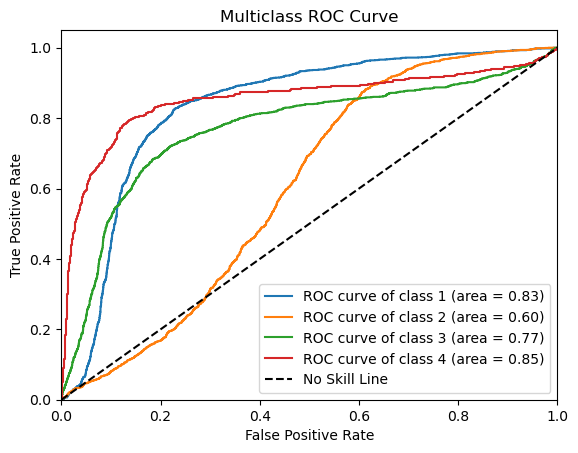

In [580]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming y_test is a 1D array of true labels, convert it to a binary matrix representation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC curve and AUC for each class
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], probabilities[:, i])

# Plot all ROC curves
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [552]:
from sklearn.decomposition import KernelPCA, PCA

# next iteration use dimensional reduction with best model from above:

estimators = [('dim_reducer', PCA()),('model', LogisticRegression(random_state=42, C=1000.0, solver='saga'))]

#build estimator list trat this as a placeholder
cachedir2 = mkdtemp()
pipe2=Pipeline(estimators, memory=cachedir2)

param_grid2 = [
            {'model':[LogisticRegression(random_state=42, C=1000.0, solver='saga')],
            'dim_reducer': [KernelPCA(kernel='linear'), KernelPCA(kernel='poly'), KernelPCA(kernel='rbf'), KernelPCA(kernel='sigmoid'), PCA()],
            'dim_reducer__n_components': [2, 3, 4, 5, 6]},

            {'model':[LogisticRegression(random_state=42, C=1000.0, solver='saga')],
             'dim_reducer': [None]}]
             

#Instantiate the GridSearch
        
grid2 = GridSearchCV(pipe2, param_grid2, cv=5)

#fit the grid search to the train data
fittedgrid2 = grid2.fit(X_train_sm_ss, y_train_sm)

#display the best estimator
fittedgrid2.best_estimator_

Pipeline(memory='/var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmp1b4071tg',
         steps=[('dim_reducer', KernelPCA(n_components=6)),
                ('model',
                 LogisticRegression(C=1000.0, random_state=42, solver='saga'))])

In [553]:
print(fittedgrid2.best_estimator_)

Pipeline(memory='/var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmp1b4071tg',
         steps=[('dim_reducer', KernelPCA(n_components=6)),
                ('model',
                 LogisticRegression(C=1000.0, random_state=42, solver='saga'))])


In [555]:
estimators = [('dim_reducer', KernelPCA(n_components=6)),('model', LogisticRegression(random_state=42, C=1000.0, solver='saga'))]

#build estimator list trat this as a placeholder
cachedir3 = mkdtemp()
pipe3=Pipeline(estimators, memory=cachedir3)

param_grid3 = [
            {'model':[LogisticRegression(random_state=42, C=1000.0, solver='saga')],
            'dim_reducer': [KernelPCA(kernel='linear'), KernelPCA(kernel='poly'), KernelPCA(kernel='rbf'), KernelPCA(kernel='sigmoid')],
            'dim_reducer__n_components': [6]}]

#Instantiate the GridSearch
        
grid3 = GridSearchCV(pipe3, param_grid3, cv=5)

#fit the grid search to the train data
fittedgrid3 = grid3.fit(X_train_sm_ss, y_train_sm)

#display the best estimator
fittedgrid3.best_estimator_

Pipeline(memory='/var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmpdsj_6u6t',
         steps=[('dim_reducer', KernelPCA(n_components=6)),
                ('model',
                 LogisticRegression(C=1000.0, random_state=42, solver='saga'))])

In [556]:
#fit the best model and evaluate use a pipeline for Kernel dim reduction prior to log regression
pipeline = Pipeline([
    ('kernel_pca', KernelPCA(n_components=6, kernel='rbf')),
    ('log_reg', LogisticRegression(C=1000.0, solver='saga', random_state=42))
])

# Fit the pipeline to the training data
pipeline.fit(X_train_sm_ss, y_train_sm)

# Now you can use pipeline to make predictions, for example:
y_pred = pipeline.predict(X_test_ss)

#score
accuracy_pipe = accuracy_score(y_test, y_pred)
precision_pipe = precision_score(y_test, y_pred, average='weighted')
recall_pipe = recall_score(y_test, y_pred, average='weighted')
f1_pipe = f1_score(y_test, y_pred, average='weighted')
conf_mat_pipe = confusion_matrix(y_test, y_pred)
clf_report_pipe = classification_report(y_test, y_pred)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_pipe}")
print(f"Precision: {precision_pipe}")
print(f"Recall: {recall_pipe}")
print(f"F1 Score: {f1_pipe}")
print("Confusion Matrix:")
print(conf_mat_pipe)
print("Classification Report:")
print(clf_report_pipe)


Logistic Regression Metrics:
Accuracy: 0.26556741028128034
Precision: 0.30021072995837367
Recall: 0.26556741028128034
F1 Score: 0.25379038760137307
Confusion Matrix:
[[278 593 192 502]
 [283 610 185 510]
 [191 457 157 606]
 [ 58 159  50 324]]
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.18      0.23      1565
           2       0.34      0.38      0.36      1588
           3       0.27      0.11      0.16      1411
           4       0.17      0.55      0.26       591

    accuracy                           0.27      5155
   macro avg       0.28      0.31      0.25      5155
weighted avg       0.30      0.27      0.25      5155



In [ ]:



#instantiate model with best parameteres from above
logreg_1 = LogisticRegression(random_state=42, C=1000.0, solver='saga')

#fit the model
logreg_1.fit(X_train_sm_ss, y_train_sm)

#make predictions
logreg_1_pred = logreg_1.predict(X_test_ss)

#compute metrics

accuracy_lg1 = accuracy_score(y_test, logreg_1_pred)
precision_lg1 = precision_score(y_test, logreg_1_pred, average='weighted')
recall_lg1 = recall_score(y_test, logreg_1_pred, average='weighted')
f1_lg1 = f1_score(y_test, logreg_1_pred, average='weighted')
conf_mat_lg1 = confusion_matrix(y_test, logreg_1_pred)
clf_report_lg1 = classification_report(y_test, logreg_1_pred)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg1}")
print(f"Precision: {precision_lg1}")
print(f"Recall: {recall_lg1}")
print(f"F1 Score: {f1_lg1}")
print("Confusion Matrix:")
print(conf_mat_lg1)
print("Classification Report:")
print(clf_report_lg1)



### KNN

### DT Classifier

In [ ]:
# Initialize the model
dec_tree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 10, 20, 30],   
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4]      
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(dec_tree, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned Decision Tree Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

### XGBoost

In [ ]:
# Initialize the model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],      
    'max_depth': [3, 5, 7],               
    'learning_rate': [0.01, 0.1, 0.2]     
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned XGBoost Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

### Random Forest


In [ ]:
# Initialize the model
rand_forest = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],         
    'max_depth': [None, 10, 20, 30],          
    'min_samples_split': [2, 5, 10],          
    'min_samples_leaf': [1, 2, 4]           
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(rand_forest, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned Random Forest Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

### SVM -OvO or OvA 
- see feature_new.ipynb

### Hyper Parameter Tuning Summary

In [ ]:
# Set the maximum column width to -1 to display all the text in a column
pd.set_option('display.max_colwidth', -1)

# Create a DataFrame with the best parameters for each model
best_params_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Best Parameters': [
        {'C': 0.1, 'penalty': 'l2'},
        {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300},
        {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
    ]
})

print(best_params_df)


# Compare Baseline Models

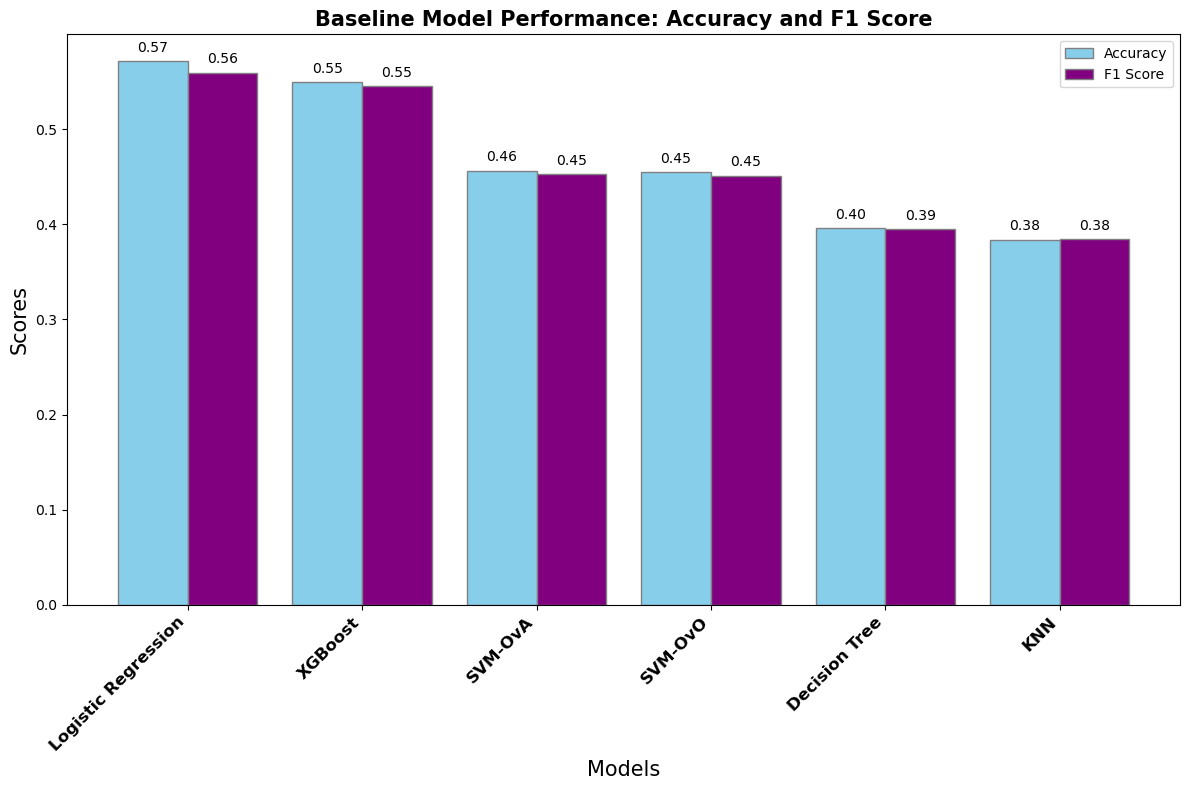

In [633]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: replace these with your actual values
accuracies = [0.5712598425196851, 0.549466537342386, 0.4561023622047244, 0.4549212598425197, 0.3957322987390883, 0.38405511811023624]
f1_scores = [0.5593325953595994, 0.5450124812739251, 0.45247088849868766, 0.45117039070858844, 0.3946680249389642, 0.3845143008061653]
model_names = ['Logistic Regression', 'XGBoost', 'SVM-OvA', 'SVM-OvO', 'Decision Tree', 'KNN']

# Set up the bar width and positions
barWidth = 0.4
acc_bars = np.arange(len(accuracies))
f1_bars = [x + barWidth for x in acc_bars]

# Create the bars
plt.figure(figsize=(12, 8))
plt.bar(acc_bars, accuracies, color='skyblue', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(f1_bars, f1_scores, color='purple', width=barWidth, edgecolor='grey', label='F1 Score')

# Add labels and title
plt.xlabel('Models', fontsize=15)
plt.ylabel('Scores', fontsize=15)
plt.xticks([r + barWidth/2 for r in range(len(accuracies))], model_names,  rotation=45, ha="right", fontweight='bold', fontsize=12)

# Create legend & Show graphic
plt.title('Baseline Model Performance: Accuracy and F1 Score', fontsize=15, fontweight='bold')
plt.legend()
plt.tight_layout()

# Adding value labels on top of each bar
for i in range(len(acc_bars)):
    plt.text(acc_bars[i], accuracies[i] + 0.01, f'{accuracies[i]:.2f}', ha = 'center')
    plt.text(f1_bars[i], f1_scores[i] + 0.01, f'{f1_scores[i]:.2f}', ha = 'center')

# Show and save the plot
plt.tight_layout()
plt.savefig('baseline_model_performance.png', format='png', dpi=300, bbox_inches='tight')

plt.show()



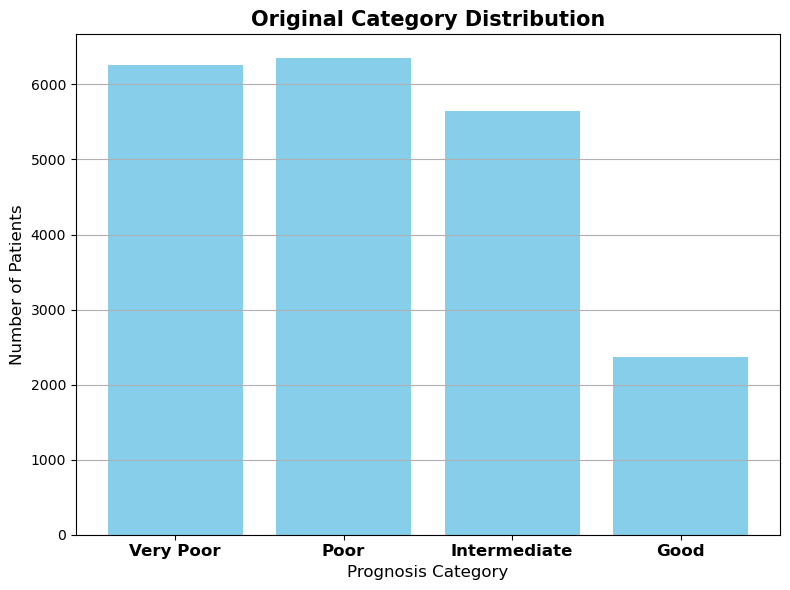

In [635]:
# Sample data: replace these with your actual values
original_class_distribution = pd.Series(y_train).value_counts().sort_index()
resampled_class_distribution = pd.Series(y_train_sm).value_counts().sort_index()

# Class labels
class_labels = {1: 'Very Poor', 2: 'Poor', 3: 'Intermediate', 4: 'Good'}

# Map the class numbers to the class labels
original_class_labels = [class_labels[i] for i in original_class_distribution.index]
resampled_class_labels = [class_labels[i] for i in resampled_class_distribution.index]

# Original class distribution plot
plt.figure(figsize=(8, 6))
plt.bar(original_class_labels, original_class_distribution, color='skyblue')
plt.title('Original Category Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Prognosis Category', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('original_category_distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


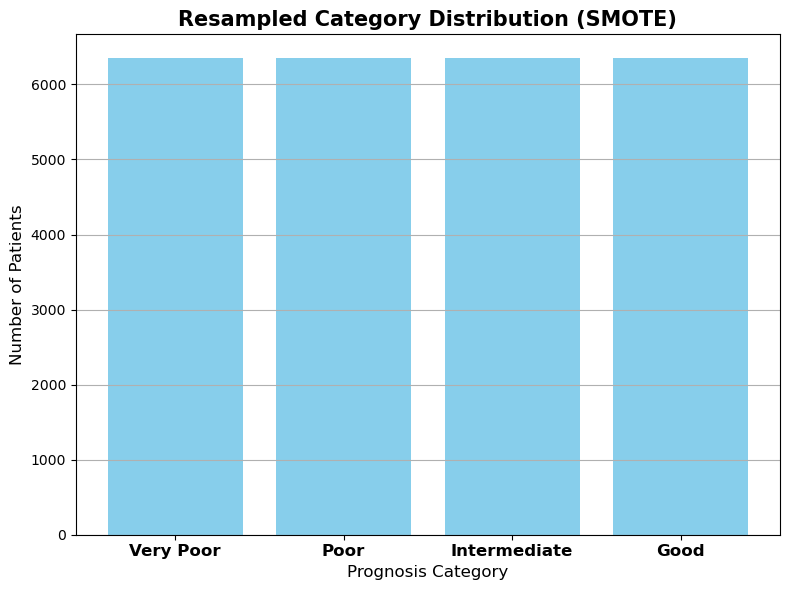

In [629]:

# Resampled class distribution plot
plt.figure(figsize=(8, 6))
plt.bar(resampled_class_labels, resampled_class_distribution, color='skyblue')
plt.title('Resampled Category Distribution (SMOTE)', fontsize=15, fontweight='bold')
plt.xlabel('Prognosis Category', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('Resampled_Category_Distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show()